# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
import cv2

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
from skimage import io

Using TensorFlow backend.


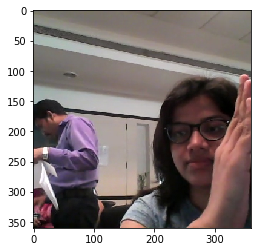

In [3]:
sample_image_path = './Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00022.png'
sample_image = io.imread(sample_image_path)
plt.imshow(sample_image)


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


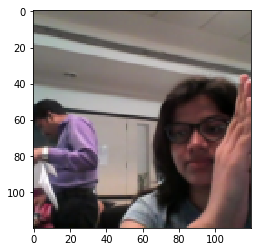

In [4]:
resized_image = imresize(sample_image, (120, 120), interp='bilinear')
plt.imshow(resized_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


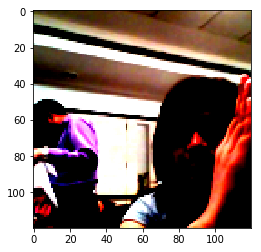

In [5]:
normalized_image = (resized_image - resized_image.mean()) / resized_image.std()
plt.imshow(normalized_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


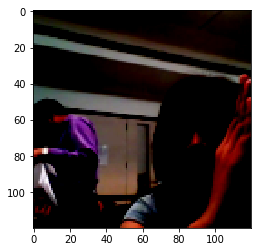

In [6]:
normalized_image = resized_image/127.5-1
plt.imshow(normalized_image)

In [7]:
from skimage import transform as trans

shift_x, shift_y = sample_image.shape[0]/2, sample_image.shape[1]/2

matrix_to_topleft = trans.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = trans.SimilarityTransform(translation=[shift_x, shift_y])

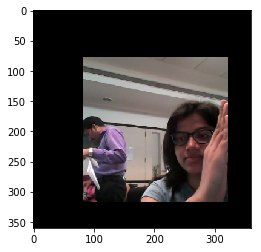

In [8]:
scale_val = 1.5
trans_x = np.random.randint(-70,70)
trans_y = np.random.randint(-70,70)
scale_transforms = trans.AffineTransform(scale=(scale_val, scale_val))
transaltion_transforms = trans.AffineTransform(translation=(trans_x, trans_y))
scale_matrix = matrix_to_topleft + scale_transforms + transaltion_transforms + matrix_to_center
scale_image_zoom_in = trans.warp(sample_image, scale_matrix)
plt.imshow(scale_image_zoom_in)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [9]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 20#experiment with the batch size
image_width = 120
image_height = 120
nb_frames = 30
nb_classes = 5

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, nb_frames)]#create a list of image numbers you want to use for a particular video
#     img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    while True:
        start_index = 0
        next_batch = 0
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_width,image_height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
             
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[0] == 360 and image.shape[1] == 360:
                        image = imresize(image, (image_width, image_height), interp='bilinear')
                    else:
                        h, w, _ = image.shape
                        image = image[int(h/2)-60:int(h/2)+60, int(w/2)-60:int(w/2)+60, : ]
#                     image = imresize(image, (image_width, image_height), interp='bilinear')
                    
                    image = (image - image.mean()) / image.std()
#                     image = image/255
#                     image = image/127.5-1
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            start_index += batch_size
            next_batch += 1
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining_images = t[start_index:]
        num_of_remaining_images = len(remaining_images)
        for folder in range(num_of_remaining_images):
            imgs = os.listdir(source_path+'/'+ t[folder + (next_batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                image = imread(source_path+'/'+ t[folder + (next_batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                h, w, _ = image.shape
                image = image[int(h/2)-60:int(h/2)+60, int(w/2)-60:int(w/2)+60, : ]
                image = imresize(image, (image_width, image_height), interp='bilinear')    
                image = (image - image.mean()) / image.std()
                
                batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image                
                
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
# from keras.layers.convolutional import Conv3D, MaxPooling3D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras import optimizers
# from keras.regularizers import l2

# #write your model here
# input_shape = (nb_frames, image_width, image_height, 3)

# #write your model here
# model = Sequential()

# model.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv3D(64, (3, 3, 3), padding='same', input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())

# model.add(Dense(256,kernel_regularizer=l2(0.01)))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(128,kernel_regularizer=l2(0.01)))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(nb_classes))
# model.add(Activation('softmax'))

In [13]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.recurrent import LSTM
from keras.applications import vgg16
from keras.regularizers import l2

num_classes = 5

# restnet = ResNet50(include_top=False, weights='imagenet')
restnet = vgg16.VGG16(include_top=False, weights='imagenet')
output = restnet.layers[-1].output
output = keras.layers.Flatten()
for layer in restnet.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(restnet))
model.add(TimeDistributed(Flatten()))
model.add(GRU(256, return_sequences=False, dropout=0.5))
model.add(BatchNormalization())

model.add(Dense(256,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.build(input_shape=(None,30,image_width,image_height,3))

In [14]:
# from keras.applications import vgg16
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
# from keras.models import Sequential, Model
# from keras.layers.convolutional import Conv2D, MaxPooling2D
# from keras import optimizers
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

# vgg = vgg16.VGG16(include_top=False, weights='imagenet')

# model = Sequential()
# model.add(TimeDistributed(vgg,input_shape=(nb_frames,image_width,image_height,3)))

# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))

# model.add(GRU(128))
# model.add(Dropout(0.25))

# model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))

In [15]:
# from keras.layers.convolutional import Conv2D, MaxPooling2D
# from keras.layers.recurrent import LSTM
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
# from keras import optimizers
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

# model = Sequential()
# model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape=(nb_frames,image_height,image_width,3)))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(64, (3, 3),padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(1024))

# model.add(Dense(512,activation='relu'))
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))
# model.add(Dropout(0.25))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [16]:
# optimiser = optimizers.SGD(lr=0.1)#write your optimizer
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 4608)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               3736320   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [17]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [18]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = DecayLR(base_lr=0.1)# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 20
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 4s - loss: 4.0731 - categorical_accuracy: 0.4047

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 92s 3s/step - loss: 4.0336 - categorical_accuracy: 0.4206 - val_loss: 3.2139 - val_categorical_accuracy: 0.6300

Epoch 00001: saving model to model_init_2020-07-0117_29_00.106487/model-00001-4.03364-0.42059-3.21389-0.63000.h5
Epoch 2/40
34/34 [==============================] - 74s 2s/step - loss: 3.1189 - categorical_accuracy: 0.6765 - val_loss: 2.7552 - val_categorical_accuracy: 0.7400

Epoch 00002: saving model to model_init_2020-07-0117_29_00.106487/model-00002-3.11885-0.67647-2.75523-0.74000.h5
Epoch 3/40
34/34 [==============================] - 71s 2s/step - loss: 2.6985 - categorical_accuracy: 0.7588 - val_loss: 2.4563 - val_categorical_accuracy: 0.8000

Epoch 00003: saving model to model_init_2020-07-0117_29_00.106487/model-00003-2.69849-0.75882-2.45633-0.80000.h5
Epoch 4/40
34/34 [==============================] - 74s 2s/step - loss: 2.3323 - categorical_accuracy: 0.8074 - val_loss: 2.2017 - val_categorical_accuracy: 0.7800

Epoch 00004:

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()